In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import KFold, StratifiedKFold
import pickle

In [3]:
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from dataset_spliter import SplitByPatient
from metrics import *#F1Weighted, MCC
from losses import *
from data_loader import ImageItemListCell
from augmentation import cutout

In [5]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [6]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [7]:
len(fnames)

10661

#### Data augmentation

In [8]:
cutout_fn = TfmLighting(cutout)
xtra_tfms=[cutout_fn(n_holes=5, length=0.1), ] #squish(scale=0.66)
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      #max_lighting=0.15, 
                      #max_zoom=1.5, 
                      #max_warp=0.2,
                      #p_affine=0.75,
                      #p_lighting=0.75,  
                      xtra_tfms=xtra_tfms,
                     )

#### Create dataset 

In [9]:
test_path = Path('/data/Datasets/WhiteBloodCancer/test/')

pat = re.compile(r'^.*(hem|all).bmp$')
def get_label(fn):
    return pat.search(str(fn)).group(1)

def get_data(bs, size, train_index, test_index):

    lls = ImageItemList(fnames, path=path)\
        .split_by_idxs(train_index, test_index)\
        .label_from_func(get_label)
    data = ImageDataBunch.create_from_ll(lls, size=size, bs=bs, ds_tfms=tfms).normalize()

    return data

In [10]:
def create_save_point(learn: Learner):
    
    preds_test, y_test=learn.get_preds(ds_type=DatasetType.Valid)# 
    preds_test = np.argmax(torch.sigmoid(preds_test), axis=1)
    score = int(matthews_corrcoef(y_test, preds_test) * 10000)
    
    name = '{}-{}-{}.pkl'.format(score, size, experiment_name)
    learn.export(name)  
    return name

In [11]:
y = []
for fn in fnames:
    if "hem.bmp" in str(fn):
        y.append(1)
    else:
        y.append(0)

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.581372,0.372057,0.155722,0.839077,0.628322
2,0.405015,0.612161,0.196998,0.809460,0.617951
3,0.344634,0.243887,0.088180,0.910754,0.793649
4,0.313652,0.331303,0.107880,0.886182,0.751269
5,0.286235,0.346838,0.157598,0.847465,0.698040
6,0.265278,0.196447,0.071295,0.928355,0.834355
7,0.252206,0.244349,0.086304,0.910283,0.801061
8,0.236479,0.186429,0.080675,0.918928,0.812514
9,0.225897,0.172383,0.063790,0.936260,0.853177
10,0.210514,0.161173,0.058161,0.941839,0.865914


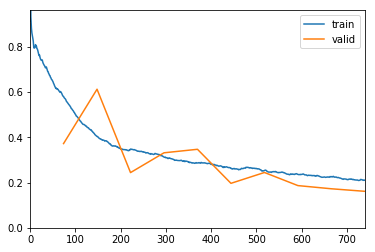

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.203200,0.167281,0.057223,0.942887,0.868644
2,0.214577,0.157351,0.060976,0.938802,0.858588
3,0.215591,0.148942,0.055347,0.943957,0.871217
4,0.212387,0.130177,0.044090,0.955749,0.897801
5,0.201819,0.152008,0.060976,0.939142,0.860027
6,0.192292,0.141323,0.050657,0.949180,0.882609
7,0.180069,0.132943,0.054409,0.946136,0.878813


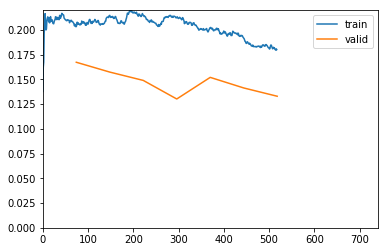

KeyboardInterrupt: 

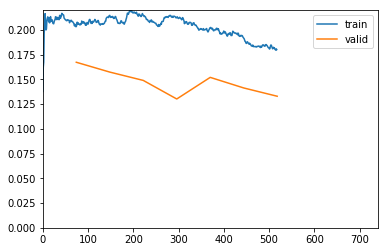

In [16]:
kf = StratifiedKFold(n_splits=10, shuffle=True) #, random_state=42
fold = 0
for train_index, test_index in kf.split(fnames, y):
    size = 256
    bs = 128

    data = get_data(bs, size, train_index, test_index)
    
    gc.collect()
    experiment_name = 'rn18-Rnd-{}'.format(fold)
    
    learn = create_cnn(data, models.resnet18, 
                   metrics=[error_rate, F1Weighted(), MCC()],  
                   #loss_func=FocalLoss(num_classes=1, alpha=0.4, gamma=0.5),
                   #ps=0.75,
                   wd=0.0001,
                   callback_fns=[ShowGraph, partial(SaveModelCallback, monitor="mcc", mode='max', name='stage1-{}-{}'.format(experiment_name, size))],
                  ).to_fp16()
    
    lr = 1e-2
    learn.fit_one_cycle(10, lr)
    

    learn.unfreeze()
    learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))
    learn.fit_one_cycle(10, slice(1e-5,lr/5))

    ####################################### 384
    
    size = 384
    bs = 96
    learn.freeze()
    
    learn.data = get_data(bs, size, train_index, test_index)
    learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage1-{}-{}'.format(experiment_name, size))
    learn.fit_one_cycle(10, slice(1e-5,lr/5))
    

    learn.unfreeze()
    learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))
    learn.fit_one_cycle(10, slice(1e-5,lr/5))
    
    create_save_point(learn)

    ####################################### 450
    
    size = 450
    bs = 64
    learn.freeze()
    
    learn.data = get_data(bs, size, train_index, test_index)
    learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage1-{}-{}'.format(experiment_name, size))
    learn.fit_one_cycle(10, slice(1e-5,lr/5))
    

    learn.unfreeze()
    learn.callback_fns[2] = partial(SaveModelCallback, 
                              monitor="mcc", 
                              mode='max', 
                              name='stage2-{}-{}'.format(experiment_name, size))
    learn.fit_one_cycle(10, slice(1e-5,lr/5))

    name = create_save_point(learn)
    
    
    # save features
    learn.model =  nn.Sequential(learn.model[0],learn.model[1][:-2])  #nn.Sequential(*list(flatten_model(learn.model)))
    result_validation = learn.get_preds(ds_type=DatasetType.Valid)
    result_train = learn.get_preds(ds_type=DatasetType.Train)

    result = {'x': np.vstack([result_validation[0], result_train[0]]),
          'y': np.hstack([result_validation[1], result_train[1]])}
    
    with open(path/'features_{}'.format(name), 'wb') as outfile:
        pickle.dump(result, outfile)
    
    fold += 1